# Velocity normalization

We normalize velocities in the Bodhidharma dataset to get rid of a mismatch with respect to the training distribution.

The histogram plotting takes a bit long and may be skipped.

In [6]:
import itertools
import os

import matplotlib.pyplot as plt
from museflow.io.note_sequence_io import NoteSequenceDB
from museflow.note_sequence_utils import filter_sequence
import numpy as np
import scipy

In [7]:
DATASET_DIR = 'bodhidharma/final'
TRAIN_DB = 'synth/train/final/all.db'

## Compute velocity statistics on training data

In [8]:
velocities_train = []
with NoteSequenceDB(TRAIN_DB) as db, db.begin() as txn:
    for _, seq in txn.items():
        velocities_train.extend(n.velocity for n in seq.notes)

In [9]:
train_stats = scipy.stats.describe(velocities_train)
train_stats

DescribeResult(nobs=71799353, minmax=(1, 127), mean=64.25399574283072, variance=432.9165195560093, skewness=0.19585816884222212, kurtosis=-0.06955028101708605)


KeyboardInterrupt



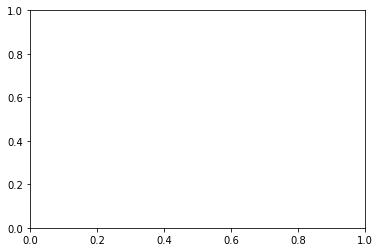

In [5]:
plt.hist(velocities_train, bins=np.linspace(0, 128, 129))
plt.show()

## Compute the same statistics on the Bodhidharma dataset

In [10]:
velocities_bodh = []
with NoteSequenceDB(os.path.join(DATASET_DIR, 'all.db')) as db, db.begin() as txn:
    for _, seq in txn.items():
        velocities_bodh.extend(n.velocity for n in seq.notes)

Error: bodhidharma/final\all.db: El sistema no puede encontrar la ruta especificada.


In [ ]:
bodh_stats = scipy.stats.describe(velocities_bodh)
bodh_stats

In [ ]:
plt.hist(velocities_bodh, bins=np.linspace(0, 128, 129))
plt.show()

## Normalize velocities and check the new statistics

In [ ]:
os.makedirs(os.path.join(DATASET_DIR, 'vel_norm_biab'))

In [ ]:
velocities_norm = []
with NoteSequenceDB(os.path.join(DATASET_DIR, 'all.db')) as db, db.begin() as txn, \
     NoteSequenceDB(os.path.join(DATASET_DIR, 'vel_norm_biab', 'all.db'), write=True,
                    map_size=2 * db.db.info()['map_size']) as db_out, db_out.begin() as txn_out:
    for key, seq in txn.items():
        seq_velocities = np.array([n.velocity for n in seq.notes])
        seq_velocities = seq_velocities - np.mean(seq_velocities)
        if np.std(seq_velocities) > 0:
            seq_velocities *= np.sqrt(train_stats.variance) / np.std(seq_velocities)
        seq_velocities += train_stats.mean
        seq_velocities = np.rint(seq_velocities).astype(np.int32)
        np.clip(seq_velocities, 1, 127, out=seq_velocities)
        for note, velocity in zip(seq.notes, seq_velocities):
            note.velocity = velocity
        txn_out.put(key, seq)
        velocities_norm.extend(seq_velocities)

In [ ]:
scipy.stats.describe(velocities_norm)

In [ ]:
plt.hist(velocities_train, density=True, bins=np.linspace(0, 128, 129), alpha=0.7)
plt.hist(velocities_norm, density=True, bins=np.linspace(0, 128, 129), alpha=0.7)
plt.show()

In [ ]:
plt.hist(velocities_train, density=True, bins=np.linspace(0, 128, 9), alpha=0.7)
plt.hist(velocities_norm, density=True, bins=np.linspace(0, 128, 9), alpha=0.7)
plt.show()

## Filter out drums

In [ ]:
with NoteSequenceDB(os.path.join(DATASET_DIR, 'vel_norm_biab', 'all.db')) as db, db.begin() as txn, \
     NoteSequenceDB(os.path.join(DATASET_DIR, 'vel_norm_biab', 'all_except_drums.db'), write=True,
                    map_size=2 * db.db.info()['map_size']) as db_out, db_out.begin() as txn_out:
    for key, seq in txn.items():
        filter_sequence(seq, drums=False)
        txn_out.put(key, seq)